In [1]:
#prepare the environment
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
sns.set_theme()

In [2]:
mushroom_df = pd.read_csv('https://datahub.io/machine-learning/mushroom/r/mushroom.csv')
mushroom_df.rename(columns={'bruises%3F':'bruises'}, inplace=True)
mushroom_df = mushroom_df.apply(lambda x: x.astype('category'))

In [3]:
mushroom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   cap-shape                 8124 non-null   category
 1   cap-surface               8124 non-null   category
 2   cap-color                 8124 non-null   category
 3   bruises                   8124 non-null   category
 4   odor                      8124 non-null   category
 5   gill-attachment           8124 non-null   category
 6   gill-spacing              8124 non-null   category
 7   gill-size                 8124 non-null   category
 8   gill-color                8124 non-null   category
 9   stalk-shape               8124 non-null   category
 10  stalk-root                5644 non-null   category
 11  stalk-surface-above-ring  8124 non-null   category
 12  stalk-surface-below-ring  8124 non-null   category
 13  stalk-color-above-ring    8124 non-null   catego

In [4]:
mushroom_df.drop('veil-type', inplace=True, axis=1)
mushroom_df['stalk-root'] = mushroom_df['stalk-root'].cat.add_categories("Unknown").fillna("Unknown")
mushroom_df['odor'] = mushroom_df['odor'].apply(lambda x: 'good' if str(x) in ['a','l'] else 'neutral' if str(x) == 'n' else 'rotten').astype('category')
mushroom_df = mushroom_df.rename(columns={'odor':"good_for_soup"})
mushroom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   cap-shape                 8124 non-null   category
 1   cap-surface               8124 non-null   category
 2   cap-color                 8124 non-null   category
 3   bruises                   8124 non-null   category
 4   good_for_soup             8124 non-null   category
 5   gill-attachment           8124 non-null   category
 6   gill-spacing              8124 non-null   category
 7   gill-size                 8124 non-null   category
 8   gill-color                8124 non-null   category
 9   stalk-shape               8124 non-null   category
 10  stalk-root                8124 non-null   category
 11  stalk-surface-above-ring  8124 non-null   category
 12  stalk-surface-below-ring  8124 non-null   category
 13  stalk-color-above-ring    8124 non-null   catego

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.linear_model import LogisticRegression

X = mushroom_df.copy()
X_factorized = X.apply(lambda x: pd.factorize(x)[0])

In [ ]:
# sns.color_palette("viridis", as_cmap=True)
plt.figure(figsize=(14,12))
sns.heatmap(X_factorized.corr(),linewidths=.1,cmap="icefire", annot=True)
plt.title('Pearson Correlation of Features', y=1.05, size=15)
plt.yticks(rotation=0);

In [11]:
import sklearn.model_selection as model_selection
y = X.pop('good_for_soup')
X_dummies = pd.get_dummies(X, prefix=list(X.columns))
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_dummies, y, test_size=0.33, random_state=13)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

[True]
[False]
[False]
[False]
(5443, 109)
(5443,)
(2681, 109)
(2681,)


Given that odor and a mushroom's classification as 'poisonous' or 'edible' are strongly negatively correlated and that odor is a direct contributor and fundamental constituent of flavor, so I will use 'odor' as the 'class' to be predicted, with a trinary categorical system of 'good', 'neutral', and 'bad' odors.  This is further supported by the following notions: few of the total mushrooms that exist are toxic both raw and post-processing, of those mushrooms which are toxic in any state even fewer are fatally so, and finally, most toxic mushrooms (other than the amanita which are famously lethal, good-smelling, and delicious) are considered to have an acrid and spicy experience which will be categorized as NGFS (not-good-for-soup) thus further reducing the probability of predicting a delicious as well as life-ending soup.  Additionally, there is the notion that I have been deep down the mushroom rabbithole for several days and am not sure what to believe about anything except that there are few if any hard and fast rules with these beautiful, amazing, crazy, harrowing, and brilliant plantimalizomes (copyright pending).  Is chicken-of-the-woods in this dataset?

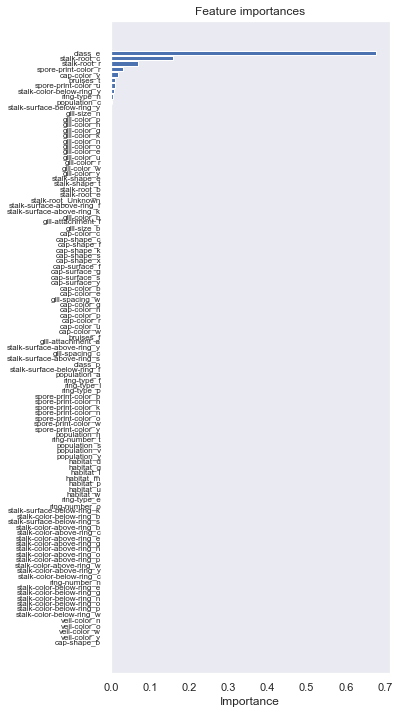

In [12]:
# determine feature importance by way of a decision tree classifier
clf = DecisionTreeClassifier()
clf = clf.fit(X_dummies, y)
features_list = X_dummies.columns.values
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)

sns.set_style("dark")
plt.figure(figsize=(5,12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.tick_params(axis='y', which='major', labelsize=8)
plt.draw()
plt.show()

We can see that there are very few 'important' variables for determining 'good_for_soup' (as a stand-in for flavor which is aggregated by 'odor') and this might be important for rule association mining if I want to have this done by the deadline.  But also, overfitting and multicollinearity could be issues if I wanted to do different models.

In [13]:
#select only features which are at least somewhat correlated to good_for_soup
cor_target = abs(X_factorized.corr()['good_for_soup'])
relevant_features = cor_target[cor_target>0.15]
columns_of_interest = list(relevant_features.index)
print(columns_of_interest)

['cap-surface', 'bruises', 'good_for_soup', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'habitat', 'class']


In [14]:
# slice and transform original dataset
X = mushroom_df[columns_of_interest].copy()
X = pd.get_dummies(X, prefix=X.columns)

## Let's try association rule mining via the Apriori algorithm

### first, we need frequent itemsets

In [15]:
from mlxtend.frequent_patterns import apriori  
from mlxtend.frequent_patterns import association_rules
freq_is = apriori(X, min_support=0.07, use_colnames=True)

In [16]:
# next, let's determine the rules
rules = association_rules(freq_is, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(bruises_f),(cap-surface_f),0.584441,0.285574,0.173314,0.296546,1.038422,0.006413,1.015598
1,(cap-surface_f),(bruises_f),0.285574,0.584441,0.173314,0.606897,1.038422,0.006413,1.057123
2,(good_for_soup_neutral),(cap-surface_f),0.434269,0.285574,0.188085,0.433107,1.516620,0.064069,1.260248
3,(cap-surface_f),(good_for_soup_neutral),0.285574,0.434269,0.188085,0.658621,1.516620,0.064069,1.657192
4,(gill-spacing_w),(cap-surface_f),0.161497,0.285574,0.079764,0.493902,1.729510,0.033644,1.411638


In [24]:
# finally, let's filter the rules to significant and relevant
nonr_rules = rules[(rules['confidence'] > 0.6)]

In [30]:
gfs_rules = nonr_rules[nonr_rules['consequents'] == frozenset({'good_for_soup_good'})]
gfs_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
54995,"(stalk-shape_e, bruises_t, gill-size_b)",(good_for_soup_good),0.123092,0.098474,0.086657,0.704000,7.149120,0.074535,3.045697
55106,"(stalk-color-above-ring_w, stalk-shape_e, brui...",(good_for_soup_good),0.143772,0.098474,0.086657,0.602740,6.120822,0.072499,2.269359
55134,"(ring-number_o, stalk-shape_e, bruises_t)",(good_for_soup_good),0.119153,0.098474,0.086657,0.727273,7.385455,0.074923,3.305597
55149,"(stalk-shape_e, bruises_t, ring-type_p)",(good_for_soup_good),0.131955,0.098474,0.086657,0.656716,6.668955,0.073663,2.626185
55163,"(stalk-shape_e, bruises_t, class_e)",(good_for_soup_good),0.114229,0.098474,0.086657,0.758621,7.703793,0.075408,3.734895


In [41]:
gfs_rules = gfs_rules.sort_values(by=['confidence', 'lift'], ascending=False)

In [80]:
print(len(gfs_rules))
print(gfs_rules.head(10))
# antecedent_list = [list(x) for x in list(gfs_rules.antecedents.values)]
# antecedent_list = list(map(sorted, antecedent_list)) 
# print(antecedent_list[0:10])

420
                                               antecedents  \
339188   (ring-number_o, stalk-shape_e, bruises_t, gill...   
340118   (ring-number_o, stalk-shape_e, bruises_t, clas...   
397570   (ring-number_o, stalk-shape_e, stalk-color-abo...   
1390861  (ring-number_o, bruises_t, gill-size_b, gill-s...   
1392783  (class_e, ring-number_o, bruises_t, gill-spaci...   
1394271  (ring-number_o, bruises_t, gill-size_b, stalk-...   
1394519  (ring-number_o, bruises_t, gill-size_b, stalk-...   
1394705  (veil-color_w, ring-number_o, bruises_t, gill-...   
1394891  (ring-number_o, bruises_t, gill-size_b, ring-t...   
1394953  (class_e, ring-number_o, bruises_t, gill-size_...   

                  consequents  antecedent support  consequent support  \
339188   (good_for_soup_good)            0.086657            0.098474   
340118   (good_for_soup_good)            0.086657            0.098474   
397570   (good_for_soup_good)            0.086657            0.098474   
1390861  (good_for_so

<AxesSubplot:xlabel='support', ylabel='confidence'>

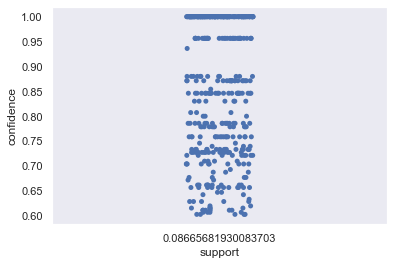

In [79]:
support = gfs_rules['support']
confidence = gfs_rules['confidence']
sns.stripplot(x=support, y=confidence,jitter=True)

This looks good enough to stop.  We've got 420 unique rules with confidence (conditional probability of occurrence of 'good_soup' given the presence of the other features) greater than 0.6 to determine whether a mushroom we're thinking about eating is likely to smell good and also taste good.  Further filters to the rule could be applied if we didn't know certain things (like whether it's edible or not), which is one of the things that makes association rules so useful.